Computed Class Weights: {0: np.float64(0.5008661206149896), 1: np.float64(289.14340101522845)}


c:\Users\punna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.6663 - loss: 0.4197 - val_accuracy: 0.9954 - val_loss: 0.2959
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9616 - loss: 0.2242 - val_accuracy: 0.9548 - val_loss: 0.2721
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9385 - loss: 0.1821 - val_accuracy: 0.9663 - val_loss: 0.2019
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9643 - loss: 0.1539 - val_accuracy: 0.9301 - val_loss: 0.2407
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9241 - loss: 0.1996 - val_accuracy: 0.9650 - val_loss: 0.1100
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9562 - loss: 0.1215 - val_accuracy: 0.9601 - val_loss: 0.1281
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9261 - loss: 0.1788 - val_accuracy: 0.9751 - val_loss: 0.0923
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9587 - loss: 0.1326 - 

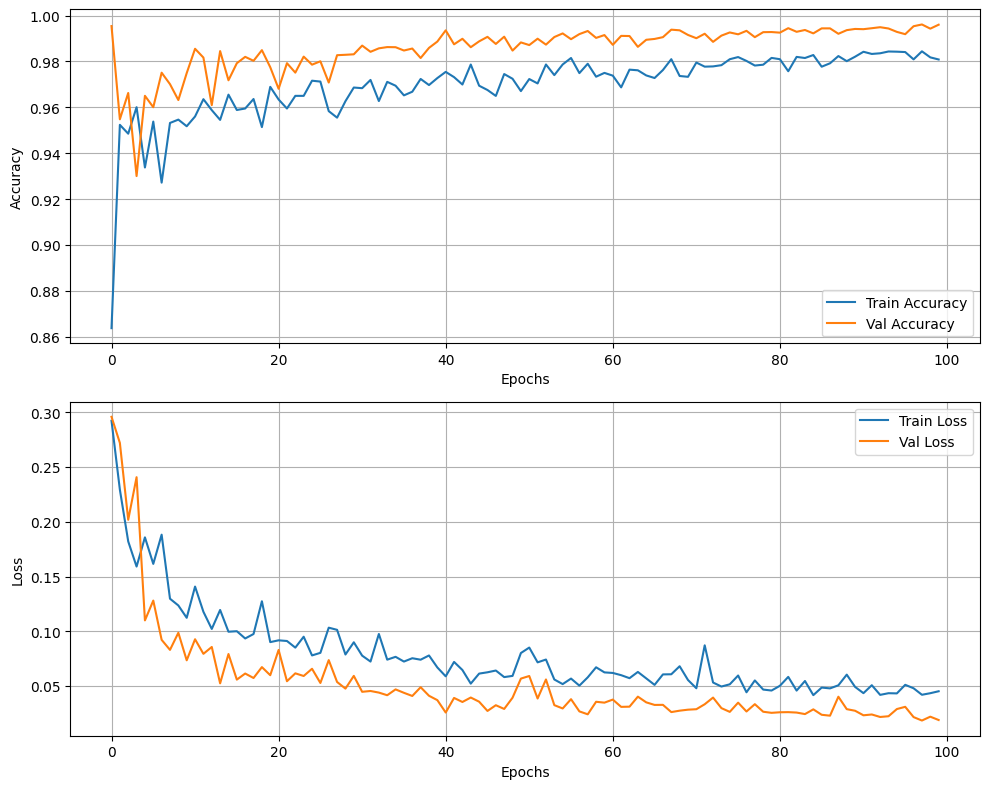

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# 1. Load Dataset
df = pd.read_csv('creditcard.csv')

# 2. Split Features and Target
X = df.drop('Class', axis=1).values
y = df['Class'].values

# 3. Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Reshape for Conv1D Layer (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# 5. Train-Test Split (Stratified to handle imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# 6. Compute Class Weights to Handle Imbalanced Data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Computed Class Weights:", class_weights_dict)

# 7. Build the Conv1D Model
model = Sequential([
    Conv1D(32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(64, kernel_size=2, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Flatten(),

    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# 8. Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 9. Train the Model with Class Weights
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=2048,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict,
    verbose=1
)

# 10. Evaluate the Final Model
print(f"\nFinal Training Accuracy:   {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy (evaluate):  {test_accuracy:.4f}")

# 11. Plot Training & Validation Accuracy/Loss
plt.figure(figsize=(10, 8))

# Accuracy Plot
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
